#Introduction

Hello 

In this notebook I will be training transformers encoder-decoder model to perform abstractive summarization of short conversations 

In [ ]:
!nvidia-smi

Wed Nov  2 19:13:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%%capture
!pip install datasets evaluate transformers[sentencepiece]
!apt install git-lfs
!pip install py7zr
!pip install rouge_score
!pip install wandb

In [ ]:
import pandas as pd
import numpy as np
import transformers
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, create_optimizer, DataCollatorForSeq2Seq
from transformers import pipeline
import wandb
import datasets
from huggingface_hub import notebook_login
from datasets import load_dataset, load_metric
from tqdm.auto import tqdm
import nltk
from nltk.tokenize import sent_tokenize
from datasets import Dataset
from transformers import Seq2SeqTrainingArguments
from transformers import Seq2SeqTrainer
from huggingface_hub import create_repo

I will be using Huggingface hub to store finetuned models and Weights&Biases for experiment tracking 

In [ ]:
notebook_login()

In [ ]:
wandb.login()

In [ ]:
%env WANDB_PROJECT=samsum_summarization

I will be using SAMSum dataset https://arxiv.org/pdf/1911.12237v2.pdf

SAMSum is a dataset composed of messenger-like conversations created and written
down by linguists fluent in English and their rather short summaries. 

In [ ]:
dataset = load_dataset('samsum')

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
})

In [ ]:
def show_example():
  sample = dataset['train'].shuffle().select([np.random.randint(0, len(dataset['train'])+1)])
  print('dialogue: \n')
  print(sample['dialogue'][0])
  print('-------------'*5)
  print('summary: \n')
  print(sample['summary'][0])

Here is a function to display random conversation and it's summary

In [ ]:
show_example()

dialogue: 

Jerry: Who ate my salad?! Was it you, Eric?
Patty: Sorry, that was me... :( I'll run to the store right now and get you a new one!! 5 minutes!
Eric: Why am I always the guilty one?
Jerry: Sorry, man. I'm just hangry, you know.
-----------------------------------------------------------------
summary: 

Patty ate Jerry's salad but will go to the store right now and buy him a new one. 


Model I decided to use is variation of t5 small which have 16 decoder and encoder layers instead of 6. I chose it as an optimal tradeoff between number of parameters and negative-log perpelxity based on figure 6a in the appendix of this paper https://arxiv.org/pdf/2109.10686.pdf



In [ ]:
model_checkpoint = 'google/t5-efficient-small-nl16'
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [ ]:
def get_lengths_dialog(batch):
  lenghts = []
  inputs = tokenizer(
      batch['dialogue']
  )
  for input_ids in inputs['input_ids']:
    lenghts.append(len(input_ids))

  return {'lenghts': lenghts}
  

In [ ]:
lengths = datasets.map(get_lengths_dialog,
                            remove_columns=datasets['train'].column_names,
                            batched=True)

In [ ]:
lengths = pd.Series(lengths['train']['lenghts'])

In [ ]:
lengths.describe()

count    14732.000000
mean       148.979297
std        110.734831
min          1.000000
25%         66.000000
50%        120.000000
75%        202.000000
max       1153.000000
dtype: float64

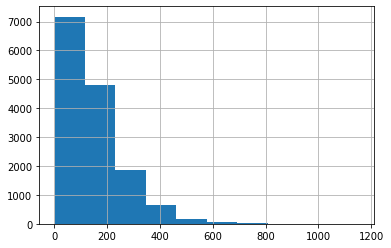

In [ ]:
lengths.hist()

In [ ]:
len(lengths[lengths > 512])

164

As you can see most of conversations are shorter than 200 tokens and only 164 examples exceedes model's maximum input lenght of 512. Examples longer than 512 tokens will be truncated

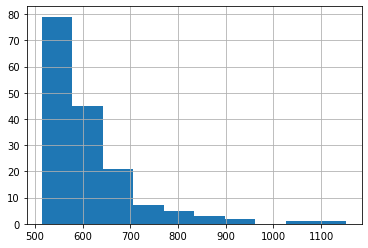

In [ ]:
lengths[lengths > 512].hist()

In [ ]:
def get_lengths_summary(batch):
  lenghts = []
  inputs = tokenizer(
      batch['summary']
  )
  for input_ids in inputs['input_ids']:
    lenghts.append(len(input_ids))

  return {'lenghts': lenghts}

In [ ]:
lengths_summary = datasets.map(get_lengths_summary,
                            remove_columns=datasets['train'].column_names,
                            batched=True)

  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
lengths_summary = pd.Series(lengths_summary['train']['lenghts'])
lengths_summary.describe()

count    14732.000000
mean        28.877410
std         15.129169
min          2.000000
25%         17.000000
50%         26.000000
75%         37.000000
max         94.000000
dtype: float64

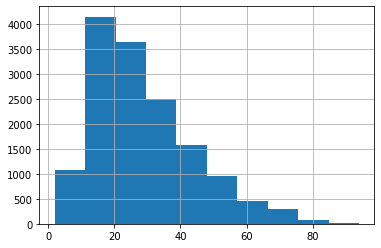

In [ ]:
lengths_summary.hist()

Longest summary in training split after tokenization have only 94 tokens


In [ ]:
max_input_length = model.config.n_positions
max_target_length = 128

def preprocess_function(batch):
  inputs = ['summarize: ' + doc for doc in batch['dialogue']]
  model_inputs = tokenizer(inputs, truncation=True, max_length=max_input_length)

  with tokenizer.as_target_tokenizer():
    labels = tokenizer(batch['summary'], truncation=True, max_length=max_target_length)

  model_inputs['labels'] = labels['input_ids']
  return model_inputs

In [ ]:
tokenized_datasets = dataset.map(preprocess_function,
                                  batched=True,
                                  remove_columns=dataset['train'].column_names)

In [ ]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 818
    })
})

Data collator will put examples in batches and dynamically pad them to the size of longest example in that batch. Dynamic padding speeds up training as there is no need to perform calculations over so many padding tokens as there would be if all examples were padded to longest exampel in the training dataset. Example is shown below 

In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors='pt')

In [ ]:
print('Input lengths')

for input_ids in tokenized_datasets["train"][:4]['input_ids']:
  print(len(input_ids))

print('Labels lengths')

for label in tokenized_datasets["train"][:4]['labels']:
  print(len(label))

Input lengths
30
29
154
57
Labels lengths
11
15
19
26


In [ ]:
out = data_collator([tokenized_datasets["train"][i] for i in range(4)])
for key in out:
    print(f"{key} shape: {out[key].shape}")

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


input_ids shape: torch.Size([4, 154])
attention_mask shape: torch.Size([4, 154])
labels shape: torch.Size([4, 26])
decoder_input_ids shape: torch.Size([4, 26])


As you can see examples shorter than 154 got padded with padding token, 0 in case of T5, and length of 3rd example is still 154 as it is the longest example in the batch

In [ ]:
out

{'input_ids': tensor([[21603,    10, 21542,    10,    27, 13635,  5081,     5,   531,    25,
           241,   128,    58, 16637,    10, 10625,    55, 21542,    10,    27,
            31,   195,   830,    25,  5721,     3,    10,    18,    61,     1,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,  

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
rouge = datasets.load_metric('rouge')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  """Entry point for launching an IPython kernel.


#Experiment 1 hyperparameter explanation:
Learning rate 5e-4: I chose value of 5e-4 because it worked well in my previous projects with models of similar size

Batch size 32, gradient accumulation steps 4: Batch size of 32 with 4 steps of gradient accumulation will simulate batch size of 128. I'm not using batch size 128 directly because it might have caused memory issues

Optimizer AdamW with default betas 0.9, 0.999: it's not specified in args because it is a default option for Trainer

Warmup ratio 5%: I chose 5% because it's a value I frequently saw in various research papers

Learning rate decay linear: Linear lr decay is a common choice I saw in many papers. Learning rate will decay to 0

Number of Epochs 10: 10 will probably be too much and model will overfit but in first experiment I decided to make this number high to see where I stand

Predict with generate True and generation num beans 5: Predictions used for calculating matrics will be generated using beam search with beam size of 5 instead of greedy decoding 

In [ ]:
batch_size = 32
num_train_epochs = 10
logging_steps = 100
model_name = model_checkpoint.split("/")[-1]

args = Seq2SeqTrainingArguments(
    output_dir=f"{model_name}-finetuned-samsum",
    evaluation_strategy="epoch",
    learning_rate=5e-4,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    lr_scheduler_type='linear',
    num_train_epochs=num_train_epochs,
    predict_with_generate=True,
    logging_steps=logging_steps,
    report_to="wandb",
    run_name='exp_1',
    logging_strategy='steps',
    save_strategy='epoch',
    logging_first_step=True,
    generation_num_beams=5,
    warmup_ratio=0.05,
    gradient_accumulation_steps=4

)

For evaluation I will be using rouge scores

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    # Decode generated summaries into text
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    # Decode reference summaries into text
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    # ROUGE expects a newline after each sentence
    decoded_preds = ["\n".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(sent_tokenize(label.strip())) for label in decoded_labels]
    # Compute ROUGE scores
    result = rouge.compute(
        predictions=decoded_preds, references=decoded_labels, use_stemmer=True
    )
    # Extract the median scores
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
    return {k: round(v, 4) for k, v in result.items()}

In [ ]:
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

#Experiment 1 results
As can be seen on plots below all 4 rouge metrics continued to improve throughout the training process. My guess that 10 epochs of training will lead to overfitting was incorrect, if I were to train this model for more epochs metrics might still improve. 

I'm going to upload the best checkpoint to huggingface hub and start another training run


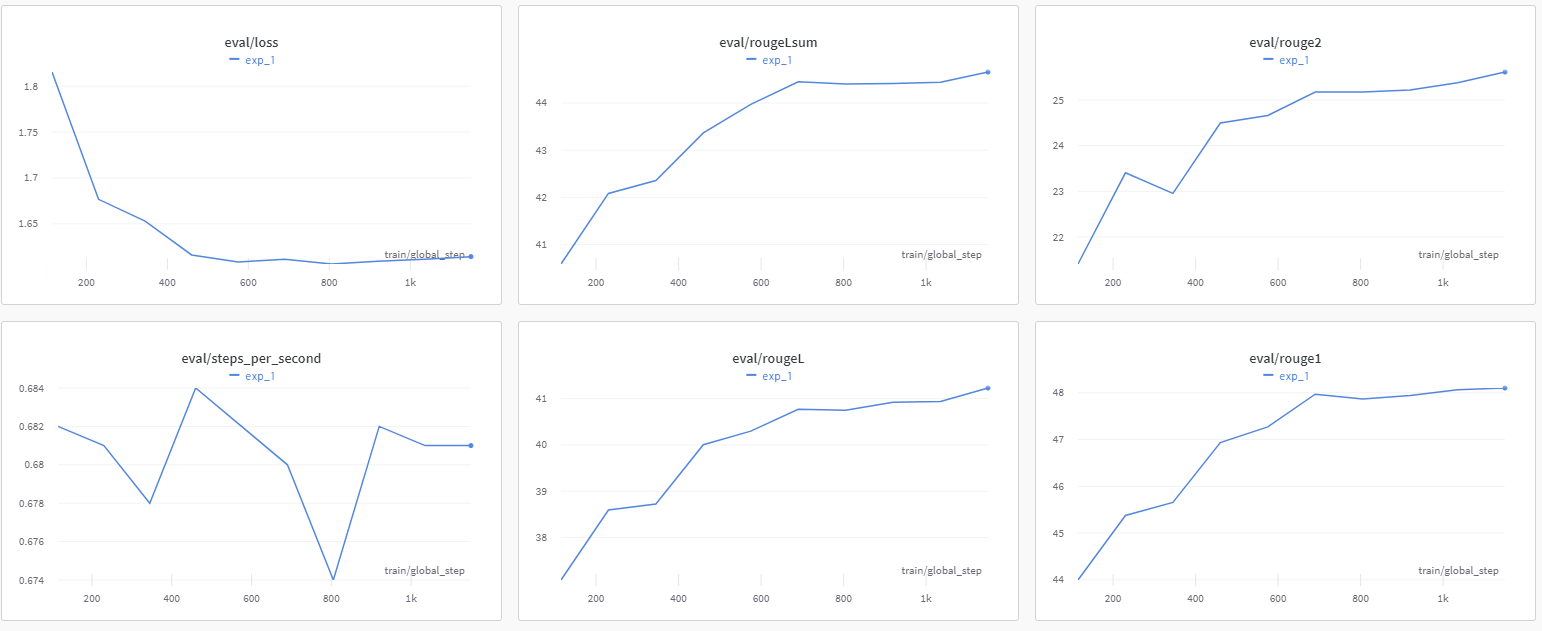

In [ ]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 14732
  Num Epochs = 10
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 1150
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
0,3.068700,1.815513,43.997800,21.410100,37.085600,40.588800
1,2.024200,1.676723,45.375900,23.406700,38.595400,42.083500
2,1.842400,1.652906,45.655000,22.956800,38.726900,42.357100
3,1.734300,1.616042,46.934500,24.496900,40.003700,43.366700
4,1.659100,1.608319,47.269800,24.662400,40.298200,43.971600
5,1.582300,1.611440,47.967900,25.175700,40.770700,44.450100
6,1.480000,1.606204,47.865200,25.173000,40.747600,44.400400
7,1.440300,1.609283,47.939700,25.218700,40.922800,44.413500
8,1.411300,1.611382,48.064400,25.378300,40.938700,44.441300
9,1.386400,1.614237,48.101100,25.613000,41.228500,44.655900


***** Running Evaluation *****
  Num examples = 818
  Batch size = 32
Saving model checkpoint to t5-efficient-small-nl16-finetuned-samsum/checkpoint-115
Configuration saved in t5-efficient-small-nl16-finetuned-samsum/checkpoint-115/config.json
Model weights saved in t5-efficient-small-nl16-finetuned-samsum/checkpoint-115/pytorch_model.bin
tokenizer config file saved in t5-efficient-small-nl16-finetuned-samsum/checkpoint-115/tokenizer_config.json
Special tokens file saved in t5-efficient-small-nl16-finetuned-samsum/checkpoint-115/special_tokens_map.json
Copy vocab file to t5-efficient-small-nl16-finetuned-samsum/checkpoint-115/spiece.model
***** Running Evaluation *****
  Num examples = 818
  Batch size = 32
Saving model checkpoint to t5-efficient-small-nl16-finetuned-samsum/checkpoint-230
Configuration saved in t5-efficient-small-nl16-finetuned-samsum/checkpoint-230/config.json
Model weights saved in t5-efficient-small-nl16-finetuned-samsum/checkpoint-230/pytorch_model.bin
tokenizer co

TrainOutput(global_step=1150, training_loss=1.7297226524353027, metrics={'train_runtime': 3182.8234, 'train_samples_per_second': 46.286, 'train_steps_per_second': 0.361, 'total_flos': 4.538781813967258e+16, 'train_loss': 1.7297226524353027, 'epoch': 10.0})

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained('/content/t5-efficient-small-nl16-finetuned-samsum/checkpoint-1150')

In [ ]:
create_repo(f"t5-efficient-small-nl16-samsum-exp1")

model.push_to_hub(f"t5-efficient-small-nl16-samsum-exp1")

tokenizer.push_to_hub(f"t5-efficient-small-nl16-samsum-exp1")

Configuration saved in /tmp/tmp_yx9v5cj/config.json
Model weights saved in /tmp/tmp_yx9v5cj/pytorch_model.bin
Uploading the following files to Gozdi/t5-efficient-small-nl16-samsum-exp1: config.json,pytorch_model.bin
tokenizer config file saved in /tmp/tmpytoms80v/tokenizer_config.json
Special tokens file saved in /tmp/tmpytoms80v/special_tokens_map.json
Copy vocab file to /tmp/tmpytoms80v/spiece.model
Uploading the following files to Gozdi/t5-efficient-small-nl16-samsum-exp1: special_tokens_map.json,tokenizer.json,spiece.model,tokenizer_config.json


CommitInfo(commit_url='https://huggingface.co/Gozdi/t5-efficient-small-nl16-samsum-exp1/commit/129f21d3ec2822f69fb21dda20721673410fda2c', commit_message='Upload tokenizer', commit_description='', oid='129f21d3ec2822f69fb21dda20721673410fda2c', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
wandb.finish()

In [ ]:
model_checkpoint

'google/t5-efficient-small-nl16'

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

#Experiment 2

I'm going to keep all hyperparameters the same except for learning rate which I doubled and it is now 1e-3

In [ ]:
batch_size = 32
num_train_epochs = 10
logging_steps = 100
model_name = model_checkpoint.split("/")[-1]

args = Seq2SeqTrainingArguments(
    output_dir=f"{model_name}-finetuned-samsum",
    evaluation_strategy="epoch",
    learning_rate=1e-3,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    lr_scheduler_type='linear',
    num_train_epochs=num_train_epochs,
    predict_with_generate=True,
    logging_steps=logging_steps,
    report_to="wandb",
    run_name='exp_2',
    logging_strategy='steps',
    save_strategy='epoch',
    logging_first_step=True,
    generation_num_beams=5,
    warmup_ratio=0.05,
    gradient_accumulation_steps=4

)

PyTorch: setting up devices


In [ ]:
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

#Experiment 2 results

Increasing learning rate resulted in higher rouge scores. Best results were achieved after 6 epochs of training, after that point the results deteriorated and were on par with those of the previous experiment.

Best results were:

Rouge1 48.5645

Rouge2 25.9046

RougeSum 45.1479

RougeL 41.5816

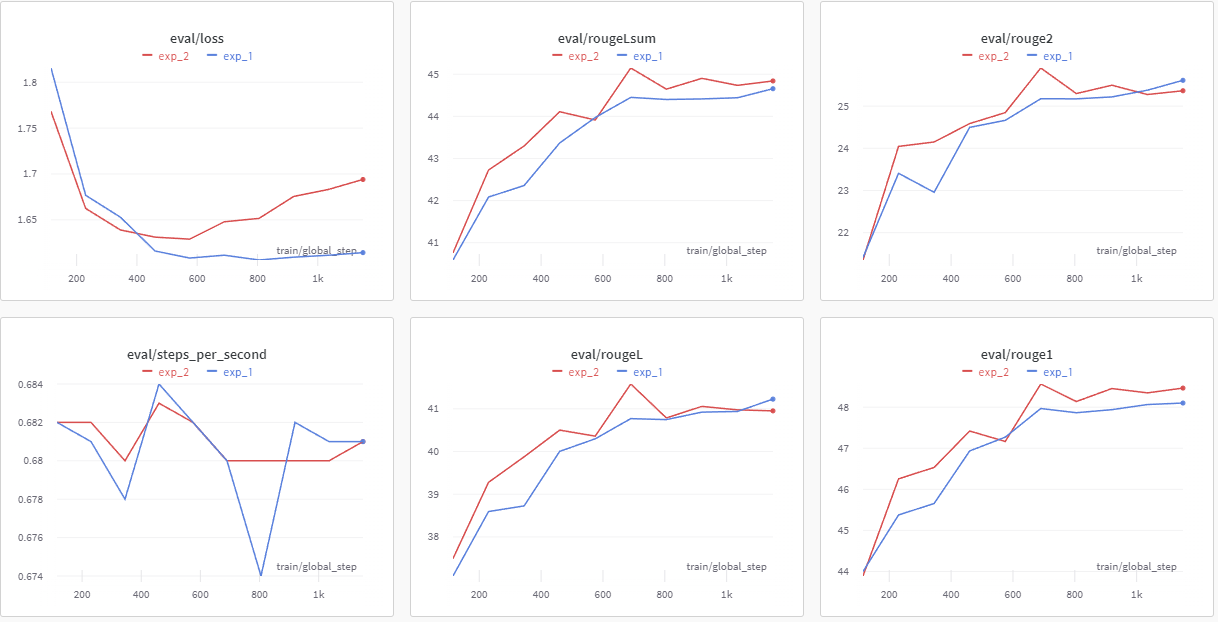

In [ ]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 14732
  Num Epochs = 10
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 1150
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
0,2.836300,1.768150,43.890100,21.350900,37.493900,40.758200
1,1.925000,1.662409,46.255400,24.045300,39.280200,42.725400
2,1.740000,1.638989,46.533100,24.149700,39.876300,43.296300
3,1.607900,1.631137,47.419900,24.586500,40.501600,44.109700
4,1.508400,1.628935,47.165400,24.845800,40.361500,43.912600
5,1.409000,1.647891,48.564500,25.904600,41.581600,45.147900
6,1.264400,1.651561,48.138000,25.297800,40.787500,44.645600
7,1.204700,1.675448,48.453900,25.495900,41.057000,44.902100
8,1.158800,1.683095,48.348300,25.275600,40.976600,44.735900
9,1.123800,1.693998,48.465500,25.364700,40.951900,44.840100


***** Running Evaluation *****
  Num examples = 818
  Batch size = 32
Saving model checkpoint to t5-efficient-small-nl16-finetuned-samsum/checkpoint-115
Configuration saved in t5-efficient-small-nl16-finetuned-samsum/checkpoint-115/config.json
Model weights saved in t5-efficient-small-nl16-finetuned-samsum/checkpoint-115/pytorch_model.bin
tokenizer config file saved in t5-efficient-small-nl16-finetuned-samsum/checkpoint-115/tokenizer_config.json
Special tokens file saved in t5-efficient-small-nl16-finetuned-samsum/checkpoint-115/special_tokens_map.json
Copy vocab file to t5-efficient-small-nl16-finetuned-samsum/checkpoint-115/spiece.model
***** Running Evaluation *****
  Num examples = 818
  Batch size = 32
Saving model checkpoint to t5-efficient-small-nl16-finetuned-samsum/checkpoint-230
Configuration saved in t5-efficient-small-nl16-finetuned-samsum/checkpoint-230/config.json
Model weights saved in t5-efficient-small-nl16-finetuned-samsum/checkpoint-230/pytorch_model.bin
tokenizer co

TrainOutput(global_step=1150, training_loss=1.5404601130278215, metrics={'train_runtime': 3186.8936, 'train_samples_per_second': 46.227, 'train_steps_per_second': 0.361, 'total_flos': 4.538781813967258e+16, 'train_loss': 1.5404601130278215, 'epoch': 10.0})

In [ ]:
wandb.finish()

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained('/content/t5-efficient-small-nl16-finetuned-samsum/checkpoint-690')

create_repo(f"t5-efficient-small-nl16-samsum-exp2")

model.push_to_hub(f"t5-efficient-small-nl16-samsum-exp2")

tokenizer.push_to_hub(f"t5-efficient-small-nl16-samsum-exp2")

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

#Experiment 3

I'm going to increase learning rate even more to 2.5e-3

In [ ]:
batch_size = 32
num_train_epochs = 10
logging_steps = 100
model_name = model_checkpoint.split("/")[-1]

args = Seq2SeqTrainingArguments(
    output_dir=f"{model_name}-finetuned-samsum-exp3",
    evaluation_strategy="epoch",
    learning_rate=2.5e-3,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    lr_scheduler_type='linear',
    num_train_epochs=num_train_epochs,
    predict_with_generate=True,
    logging_steps=logging_steps,
    report_to="wandb",
    run_name='exp_3',
    logging_strategy='steps',
    save_strategy='epoch',
    logging_first_step=True,
    generation_num_beams=5,
    warmup_ratio=0.05,
    gradient_accumulation_steps=4

)

PyTorch: setting up devices


In [ ]:
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

#Experiment 3 results

Increasing learning rate to 2.5e-3 did have a positive effect on the first 4 epochs, at that point results were better that those of last 2 experiments but they didn't beat the best results from experiment 2. 

After 10 epochs of training results were almost identical for all three experiments

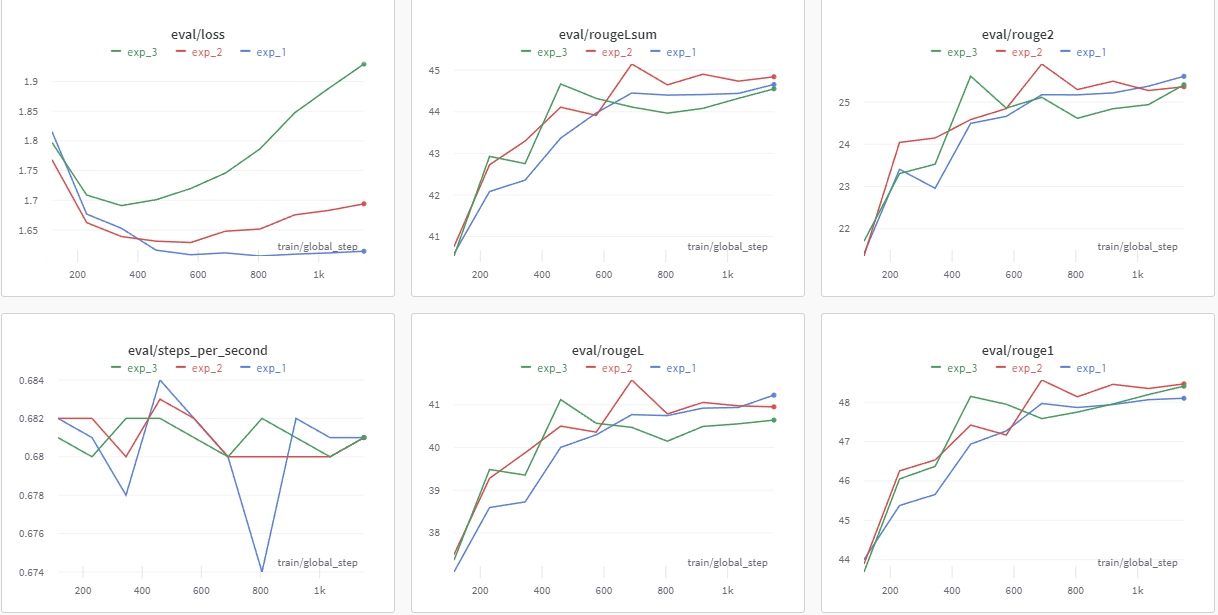

In [ ]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 14732
  Num Epochs = 10
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 1150
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
0,2.647100,1.797176,43.685700,21.700000,37.362900,40.533400
1,1.911500,1.708773,46.050400,23.306700,39.485700,42.927700
2,1.693800,1.691033,46.370200,23.528100,39.354900,42.753900
3,1.524300,1.700875,48.147500,25.616700,41.121700,44.667200
4,1.388700,1.719765,47.947800,24.858500,40.568100,44.321200
5,1.255000,1.745727,47.583800,25.114400,40.472000,44.113900
6,1.034300,1.786483,47.748100,24.616600,40.148800,43.965700
7,0.938200,1.847206,47.955200,24.843900,40.494000,44.082000
8,0.860800,1.889056,48.194100,24.941000,40.555000,44.322600
9,0.800100,1.929345,48.408400,25.411200,40.643100,44.550500


***** Running Evaluation *****
  Num examples = 818
  Batch size = 32
Saving model checkpoint to t5-efficient-small-nl16-finetuned-samsum-exp3/checkpoint-115
Configuration saved in t5-efficient-small-nl16-finetuned-samsum-exp3/checkpoint-115/config.json
Model weights saved in t5-efficient-small-nl16-finetuned-samsum-exp3/checkpoint-115/pytorch_model.bin
tokenizer config file saved in t5-efficient-small-nl16-finetuned-samsum-exp3/checkpoint-115/tokenizer_config.json
Special tokens file saved in t5-efficient-small-nl16-finetuned-samsum-exp3/checkpoint-115/special_tokens_map.json
Copy vocab file to t5-efficient-small-nl16-finetuned-samsum-exp3/checkpoint-115/spiece.model
***** Running Evaluation *****
  Num examples = 818
  Batch size = 32
Saving model checkpoint to t5-efficient-small-nl16-finetuned-samsum-exp3/checkpoint-230
Configuration saved in t5-efficient-small-nl16-finetuned-samsum-exp3/checkpoint-230/config.json
Model weights saved in t5-efficient-small-nl16-finetuned-samsum-exp3/

TrainOutput(global_step=1150, training_loss=1.3596257359048594, metrics={'train_runtime': 3176.6246, 'train_samples_per_second': 46.376, 'train_steps_per_second': 0.362, 'total_flos': 4.538781813967258e+16, 'train_loss': 1.3596257359048594, 'epoch': 10.0})

In [ ]:
wandb.finish()

#Experiment 4

Increasing learning rate to 2.5e-3 didn't make the model outperform model from experiment 2 so let's go back to learning rate of 1e-3 but this time I'm going to train only for 6 epochs making lr decay faster. I'm also going to reduce weight decay to 0.001

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

In [ ]:
batch_size = 32
num_train_epochs = 6
logging_steps = 100
model_name = model_checkpoint.split("/")[-1]

args = Seq2SeqTrainingArguments(
    output_dir=f"{model_name}-finetuned-samsum-exp4",
    evaluation_strategy="epoch",
    learning_rate=1e-3,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.001,
    lr_scheduler_type='linear',
    num_train_epochs=num_train_epochs,
    predict_with_generate=True,
    logging_steps=logging_steps,
    report_to="wandb",
    run_name='exp_4',
    logging_strategy='steps',
    save_strategy='epoch',
    logging_first_step=True,
    generation_num_beams=5,
    warmup_ratio=0.05,
    gradient_accumulation_steps=4

)

In [ ]:
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

#Experiment 4 results

Training for less epochs and reducing weight decay didn't improve model performance. At the end of training metrics are almost on the same level as they were after final epoch of all the other experiments

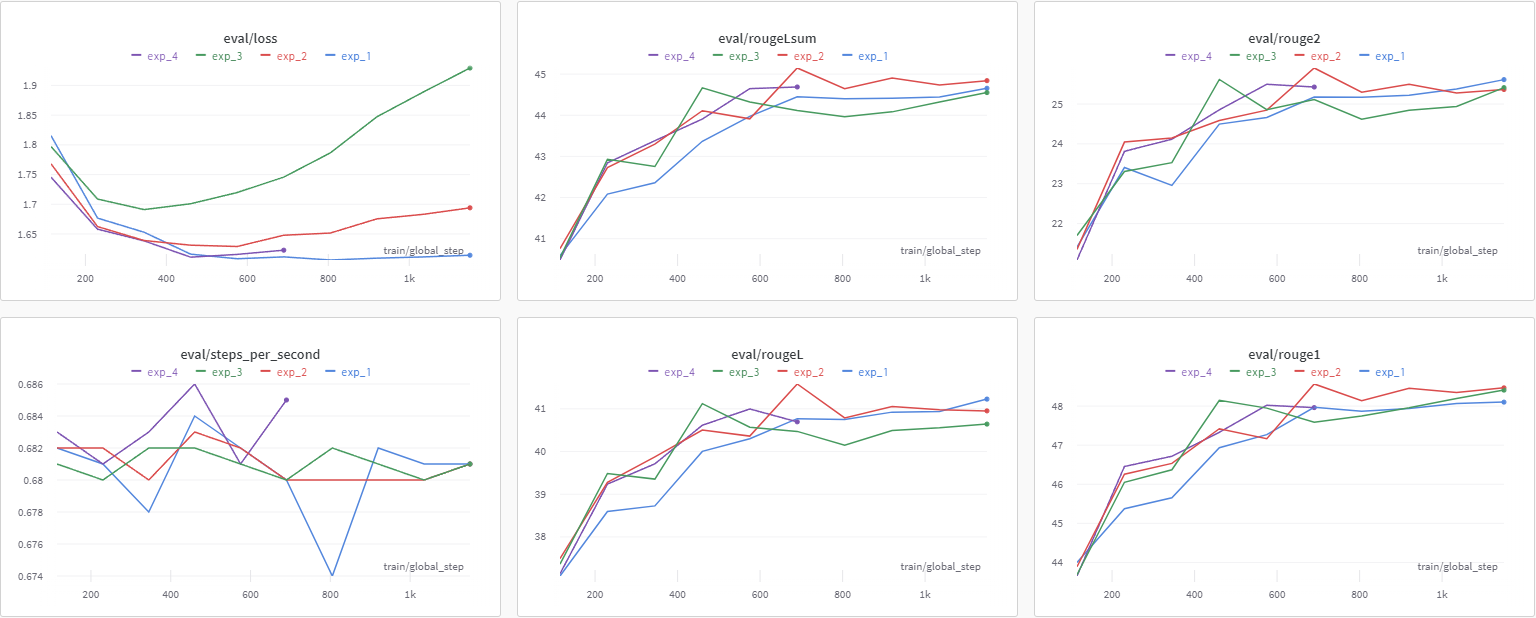

In [ ]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 14732
  Num Epochs = 6
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 690
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


wandb: Currently logged in as: gozdi. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
0,2.715600,1.745581,43.653000,21.085200,37.137700,40.482000
1,1.905800,1.658016,46.454700,23.812900,39.237700,42.842300
2,1.732500,1.638405,46.716200,24.117900,39.712300,43.381500
3,1.606800,1.610961,47.329400,24.854800,40.616400,43.907600
4,1.517900,1.615638,48.021100,25.496200,40.997000,44.646200
5,1.433500,1.622739,47.960600,25.426800,40.695600,44.686800


***** Running Evaluation *****
  Num examples = 818
  Batch size = 32
Saving model checkpoint to t5-efficient-small-nl16-finetuned-samsum-exp4/checkpoint-115
Configuration saved in t5-efficient-small-nl16-finetuned-samsum-exp4/checkpoint-115/config.json
Model weights saved in t5-efficient-small-nl16-finetuned-samsum-exp4/checkpoint-115/pytorch_model.bin
tokenizer config file saved in t5-efficient-small-nl16-finetuned-samsum-exp4/checkpoint-115/tokenizer_config.json
Special tokens file saved in t5-efficient-small-nl16-finetuned-samsum-exp4/checkpoint-115/special_tokens_map.json
Copy vocab file to t5-efficient-small-nl16-finetuned-samsum-exp4/checkpoint-115/spiece.model
***** Running Evaluation *****
  Num examples = 818
  Batch size = 32
Saving model checkpoint to t5-efficient-small-nl16-finetuned-samsum-exp4/checkpoint-230
Configuration saved in t5-efficient-small-nl16-finetuned-samsum-exp4/checkpoint-230/config.json
Model weights saved in t5-efficient-small-nl16-finetuned-samsum-exp4/

TrainOutput(global_step=690, training_loss=1.768792676234591, metrics={'train_runtime': 1916.3569, 'train_samples_per_second': 46.125, 'train_steps_per_second': 0.36, 'total_flos': 2.728139517923328e+16, 'train_loss': 1.768792676234591, 'epoch': 6.0})

In [ ]:
wandb.finish()

#Evaluating the best model on test set

The best performing model is the one from second experiment. It has been saved to huggingface hub so I'm going to download it from there and test in on testing set

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained('Gozdi/t5-efficient-small-nl16-samsum-exp2')

Downloading:   0%|          | 0.00/765 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--Gozdi--t5-efficient-small-nl16-samsum-exp2/snapshots/c16dd4db84729cce5ce6be09fcfedc6e201c53a6/config.json
Model config T5Config {
  "_name_or_path": "Gozdi/t5-efficient-small-nl16-samsum-exp2",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 512,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 16,
  "num_heads": 8,
  "num_layers": 16,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "torch_dtype": "float32",
  "transformers_version": "4.23.1",
  "use_cache": true,
  "vocab_size": 32128
}



Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--Gozdi--t5-efficient-small-nl16-samsum-exp2/snapshots/c16dd4db84729cce5ce6be09fcfedc6e201c53a6/pytorch_model.bin
All model checkpoint weights were used when initializing T5ForConditionalGeneration.

All the weights of T5ForConditionalGeneration were initialized from the model checkpoint at Gozdi/t5-efficient-small-nl16-samsum-exp2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use T5ForConditionalGeneration for predictions without further training.


Using trainer will automaticly upload results to weights and biases

In [ ]:
args = Seq2SeqTrainingArguments(
    output_dir=f"{model_name}-finetuned-samsum-exp4",
    evaluation_strategy="epoch",
    learning_rate=1e-3,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.001,
    lr_scheduler_type='linear',
    num_train_epochs=num_train_epochs,
    predict_with_generate=True,
    logging_steps=logging_steps,
    report_to="wandb",
    run_name='final_test',
    logging_strategy='steps',
    save_strategy='epoch',
    logging_first_step=True,
    generation_num_beams=5,
    warmup_ratio=0.05,
    gradient_accumulation_steps=4

)

PyTorch: setting up devices


In [ ]:
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [ ]:
test_metrics = trainer.evaluate()

***** Running Evaluation *****
  Num examples = 819
  Batch size = 32


Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


#Test set metrics

Results on test set are worse than on validation set.  Judging from the graphs, the difference may seem big but it's the scale of the graphs that causes this effect

Let's look at results metric by meterics

Rouge1: Valid 48.5645 Test 47.2864 

Rouge 2: Valid 25.9046 Test 23.6196

RougeSum: Valid 45.1479 Test 43.2821

RougeL: Valid 41.5816 Test 39.619


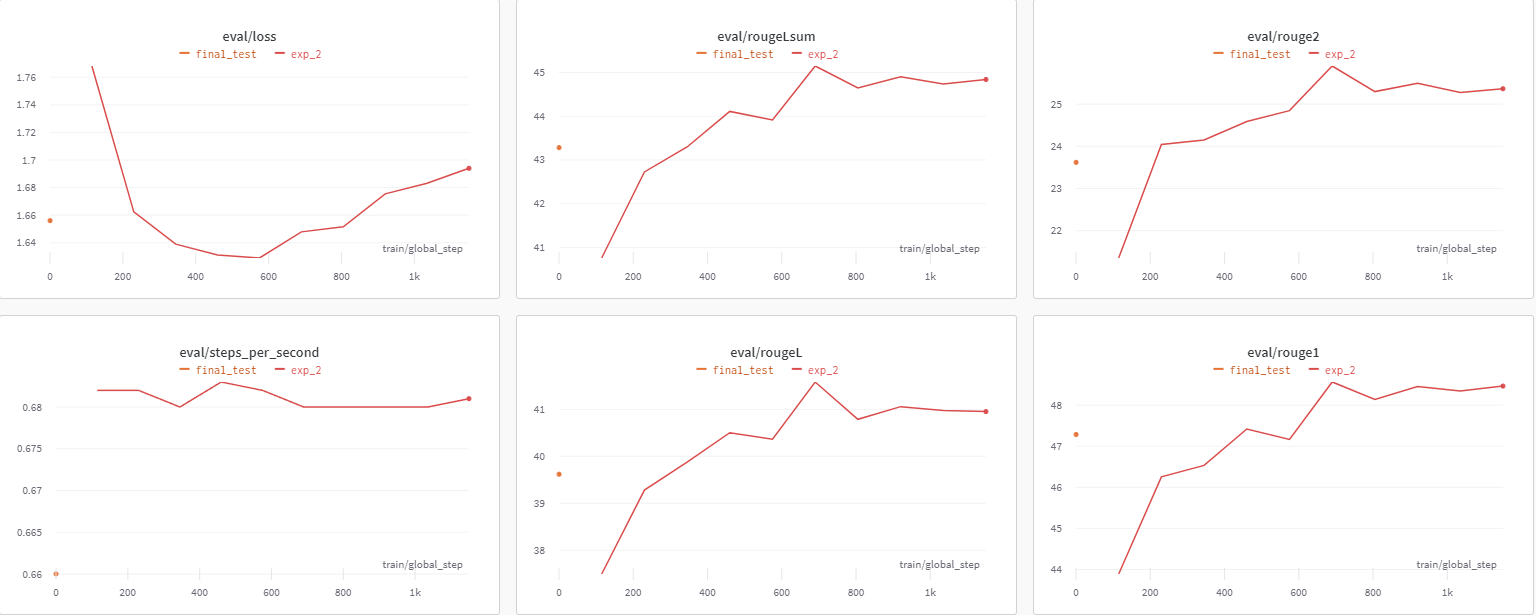

In [ ]:
pd.DataFrame(test_metrics, index=[0])

,eval_loss,eval_rouge1,eval_rouge2,eval_rougeL,eval_rougeLsum,eval_runtime,eval_samples_per_second,eval_steps_per_second
0,1.655984,47.2864,23.6196,39.619,43.2821,39.3665,20.805,0.66


In [ ]:
wandb.finish()

#Using the model

Summaries will be generated with beam search with number of beams equal to 10 and a second summary will be generated with typical sampling https://arxiv.org/pdf/2202.00666.pdf. I want to test typical sampling and comapre it to beam search. I'm setting maximum length of summary to 100 not to limit the model. Pipeline be default uses max length from models config and in case of t5 it was only 20 stopping some predictions in the middle of a sentence.

In [ ]:
summarizer = pipeline("summarization", model='Gozdi/t5-efficient-small-nl16-samsum-exp2')

In [ ]:
def print_summary(idx=None):
  if type(idx) == type(None):
    idx = np.random.randint(0, len(dataset['test'])+1)
  sample = dataset['test'][idx]
  print('dialogue: \n')
  print(sample['dialogue'])
  print('-------------'*5)
  print('summary from dataset: \n')
  print(sample['summary'])
  print('-------------'*5)
  print('generated summary beam search: \n')
  print(summarizer(sample['dialogue'], num_beams=10, max_length=100)[0]['summary_text'])
  print('-------------'*5)
  print('generated summary typical sampling: \n')
  print(summarizer(sample['dialogue'], typical_p=0.9, top_k=40, max_length=100, do_sample=True)[0]['summary_text'])

In this beam search summary Igor's gender was confused in the first sentence but it's correct in the second one. Besides this in my opinion is as good as ground truth one. 

Typical sampling summary is simmilar to beam search one but worse in my opinion, it also confuses Igors gender.

In [ ]:
print_summary(17)

dialogue: 

Igor: Shit, I've got so much to do at work and I'm so demotivated. 
John: It's pretty irresponsible to give that much work to someone on their notice period.
Igor: Yeah, exactly! Should I even care?
John: It's up to you, but you know what they say...
Igor: What do you mean?
John: Well, they say how you end things shows how you really are...
Igor: And now how you start, right?
John: Gotcha! 
Igor: So what shall I do then? 
John: It's only two weeks left, so grit your teeth and do what you have to do. 
Igor: Easy to say, hard to perform.
John: Come on, stop thinking, start doing! 
Igor: That's so typical of you!  ;)  
-----------------------------------------------------------------
summary from dataset: 

Igor has a lot of work on his notice period and he feels demotivated. John thinks he should do what he has to do nevertheless. 
-----------------------------------------------------------------
generated summary beam search: 

Igor is demotivated because she has a lot of wo

Beam search and typical sampling summaries both say that Ashleigh got a job at the cinema. I would interpret this conversation as Ashleigh and Peter are going to the cinema to celebrate the fact that she got the job but I think that even some humans might think that she got a job at the cinema. 

In [ ]:
print_summary(90)

Your max_length is set to 100, but you input_length is only 65. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)


dialogue: 

Ashleigh: Looks like we're going to the cinema!! 
Ashleigh: <file_gif>
Peter: You got the job??
Ashleigh: I got hte job! :D
Peter: <file_gif>
Ashleigh: <file_gif>
-----------------------------------------------------------------
summary from dataset: 

Ashleigh got the job.
-----------------------------------------------------------------
generated summary beam search: 



Your max_length is set to 100, but you input_length is only 65. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)


Ashleigh got a job at the cinema.
-----------------------------------------------------------------
generated summary typical sampling: 

Ashleigh got a job at the cinema.


Beam search summary says that daisy is in 4 places at the same time which obviously doesn't make sense but she will be in these places in the future. Rest of the summary is in line with the facts but it doesn't say that Daisy and Charlie have met before

Typical sampling summary gets current location of Daisy right but hallucinate the fact that charlie will take a ferry to Florence and also repeats itself about Charlie goint to Florence

In [ ]:
print_summary(700)

dialogue: 

Charlie: How are you doing.
Daisy: Good, seeing a lot of beautiful places
Charlie: Where are you now?
Daisy: in Naples 
Charlie: Pity, I hoped you may be still in Sicily.
Daisy: No, we took a ferry early in the morning yesterday.
Charlie: I am still thinking about the evening we spent together.
Daisy: Yes, it was nice.
Charlie: I would like to meet you again.
Daisy: But where?
Charlie: Either in the US or here.
Daisy: But we're heading North now. Rome, Florence, Venice.
Charlie: And you're flying to NY?
Daisy: No, directly to San Fransisco.
Charlie: Too bad.
Daisy: I know.
Charlie: I think I will take a train to Florence.
Daisy: wow, are you sure?
Charlie: More than sure. When are you going to be there?
Daisy: 1-5 of September.
Charlie: Perfect. I want to see this amazing city with you.
Daisy: I am looking forward to it!
Charlie: Me too!
-----------------------------------------------------------------
summary from dataset: 

Daisy is in Naples. Charlie recalls their meetin

Both summaries are valid and almost identical to the ground truth one

In [ ]:
print_summary(560)

Your max_length is set to 100, but you input_length is only 52. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


dialogue: 

Oscar: A coffee at Tristano's?
Payne: Why not. in 15 mins?
Oscar: let's make it half an hour ok?
Payne: great, i'll be there
Oscar: see you there
-----------------------------------------------------------------
summary from dataset: 

Payne and Oscar will have a coffee at Tristano's in half an hour.
-----------------------------------------------------------------
generated summary beam search: 



Your max_length is set to 100, but you input_length is only 52. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


Oscar and Payne will have a coffee at Tristano's in half an hour.
-----------------------------------------------------------------
generated summary typical sampling: 

Oscar and Payne will meet for a coffee at Tristano's in half an hour. 


Beam search summary theoretically sticks to the facts but doesn't specifying to whom 'his' refer to in 'watch some of his stand-ups'. It's not said in the conversation who is the autor of the stand up they are talking about, if it was said model probably would use it instead of his. It is a mistake but a reasonable one. 

Typical sampling summary would be great with the word Russian as it's not said that author is a Russian.

In [ ]:
print_summary(1)

dialogue: 

Eric: MACHINE!
Rob: That's so gr8!
Eric: I know! And shows how Americans see Russian ;)
Rob: And it's really funny!
Eric: I know! I especially like the train part!
Rob: Hahaha! No one talks to the machine like that!
Eric: Is this his only stand-up?
Rob: Idk. I'll check.
Eric: Sure.
Rob: Turns out no! There are some of his stand-ups on youtube.
Eric: Gr8! I'll watch them now!
Rob: Me too!
Eric: MACHINE!
Rob: MACHINE!
Eric: TTYL?
Rob: Sure :)
-----------------------------------------------------------------
summary from dataset: 

Eric and Rob are going to watch a stand-up on youtube.
-----------------------------------------------------------------
generated summary beam search: 

Eric will watch some of his stand-ups on youtube.
-----------------------------------------------------------------
generated summary typical sampling: 

Rob and Eric are talking about Russian stand-ups.


This conversation is longer than the previous ones and it affects summaries quality. Beam search summary makes sense logically besides the last sentence but it mixes up facts

Typical sampling summary doesn't make any seans, it is just a bunch of random words from conversation mixed together.

In [ ]:
print_summary(430)

dialogue: 

Nathan: Hey Honey, what are our plans for tomorrow then?
Deborah: So I've been thinking that we should pack everything today, we won't have time tomorrow
Nathan: Totally true, I started packing my stuff in the bedroom, I also told the girls to start packing too
Deborah: If Sofie wants to take the unicorn we won't have much space in the car XD
Nathan: No, I explained to her that he'll be fine without her these few days, I hope it worked :D
Deborah: We need to take boots and those warm jackets for the girls, my parents promised them to take them on a trip to the forest
Nathan: I remember, Lucy was really excited about that. Are we taking the bicycles?
Deborah: Yeah, don't you think we could use some alone time while the rest of the family is hiking? XD
Nathan: Now you're talking! We could have a ride to this beautiful cliff where we were last year!
Deborah: Why not, it's a wonderful idea! :*
Nathan: So tomorrow I'm seeing the dentist after work, you go to pick up the girls fr

Beam search summary gets the facts right except for the fact that Judie's girlfriend got a tatto at Warsaw ink and summary says just Warsaw but Warsaw ink could and probably is located in the city of Warsaw. It also misses the fact that Javier wanted to have a tatoo done there but it's not said directly and thats probably the reason. 

Typical sampling summary confusses the fact that it was Judie's girlfirend not Judie who got a tatoo at Warsaw ink, it also says that Javier wants to get a tatoo in Mexico instead of Colombia

In [ ]:
print_summary(432)

dialogue: 

Javier: Hey do you know any tattoo parlors over here with English speaking employees?
Judie: Oh there's Warsaw ink
Javier: the name sounds neat... have you had a tattoo done there?
Judie: nope but my gf has
Javier: got a pic?
Judie: <file_photo>
Javier: wow that looks amazing
Javier: how much did she pay?
Judie: it was a 1000
Javier: fuck
Javier: let me just get a tatttoo back in colombia then, thx
-----------------------------------------------------------------
summary from dataset: 

Javier was initially eager to have a tatoo done at Warsaw Ink but the price turned out to be too high. Javier decided to have a tatoo done in Colombia.
-----------------------------------------------------------------
generated summary beam search: 

Judie's girlfriend has a tattoo done in Warsaw. Javier wants to get a tattoo back in colombia.
-----------------------------------------------------------------
generated summary typical sampling: 

Judie had a tattoo done at Warsaw ink at a pri

#Conclusions

Beam search summaries consist of one or more short sentences and each one of them reports some fact from the conversation. Some things are not stated explicitly and need to be inferred from the context and model isn't capable of doing it. Model tries to use exact same words as in conversation sometimes resulting in false sentences. When conversations are much longer that average model omits some facts or mixes couple of them into one sentence that's untrue. In one of the examples model confused the gender of the person. Overall almost all of the sentences make sense from logical point of view.

Typical sampling have the same problems as beam search ones but multiple sentences reporting the same fact can be observed. In case of a longer than average conversation summary was more chaotic

There is a mistake I made during training. Max length of generated summary was set to 20 tokens in models config and I wasn't aware of it untill I generated summaries in the section above. This mistake lowered the results and might have resulted in not choosing the best model as a final model. Unfortunately I'm not able to fix this mistake without repeating training. I'm not able to reevaluate all the training checkpoints as they were stored in colab's temoral memory and got deleated. This didn't affect training because tokens used to calculate loss function are chosen greedily.

Main purpose of this notebook is to show my ability to pick and train right model on a specific task such as abstractive summary and in my opinion goal was achieved. I'm not going to fix my mistake mentioned above because that would require a lot of time and as I said the goal wasn't to make a perfect model ready for production. I think that noticing and mentioning this mistake is enough.
